# import all required library and dependency

In [1]:
import os
from glob import glob
import time

import numpy as np
import pandas as pd
import cv2
import imageio

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from albumentations import HorizontalFlip, VerticalFlip, Rotate

# Set up Colab GPU runtime Environment

In [2]:
!pip install segmentation-models-pytorch
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install --upgrade opencv-contrib-python

In [3]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# Setup configurations

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device use ',DEVICE)

EPOCHS = 20
LR = 0.003
IMAGE_SIZE = 320

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


Device use  cpu


# ALL uses Directory and Path

In [5]:
# Define the path to the dataset directory.
data_path = "/content/drive/MyDrive/Halliburton/Project/stone_dataset/"

# directory to save augmented data
aug_data_dir="/content/drive/MyDrive/Halliburton/Project/aug_data/"

# directory to save augmented images
aug_img_data_dir="/content/drive/MyDrive/Halliburton/Project/aug_data/image/"
# directory to save augmented masks
aug_masks_data_dir="/content/drive/MyDrive/Halliburton/Project/aug_data/mask/"


# Define the path to save the best model
best_model_path = "/content/drive/MyDrive/Halliburton/Project/best_model.pt"

In [6]:
df = pd.DataFrame(columns=['images', 'masks'])
df

,images,masks


In [7]:
def load_data(path):
    """
    Load data from specified path.

    Args:
    path (str): Path to the directory containing image and mask files.

    Returns:
    tuple: A tuple containing two lists - masks and images.
        masks (list): List of file paths to mask images.
        images (list): List of file paths to original images.
    """
    images = sorted(glob(os.path.join(path, "Ground_Truth", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "Training_Images", "*.JPG")))

    return masks, images


# Apply augmentation on data to increase no of data

In [8]:
def augment_data(images, masks, save_path, augment=True):
    """
    Augment data by applying various transformations to images and masks.
        1.HorizontalFlip
        2.VerticalFlip
        3.Rotate

    Args:
    images (list): List of file paths to original images.
    masks (list): List of file paths to mask images.
    save_path (str): Path to save the augmented images and masks.
    augment (bool, optional): Flag indicating whether to augment data. Defaults to True.

    Returns:
    None
    """
    size = (320, 320)
    data_no = 0

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)  # Applying horizontal flip
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)  # Applying vertical flip
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)  # Applying rotation
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            df.loc[data_no, 'images'] = image_path
            df.loc[data_no, 'masks'] = mask_path
            data_no += 1

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [9]:
""" Create a directory """
def create_dir(path):
    """
    Create a directory if it doesn't exist.

    Args:
    path (str): Path of the directory to create.

    Returns:
    None
    """
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
""" Load the data """

# Call the load_data function to load images and masks from the specified path.
images, masks = load_data(data_path)

# Print the number of available images and masks.
print(f"Avaliable data length -> images: {len(images)} masks: {len(masks)}")

Avaliable data length -> images: 20 masks: 20


In [11]:
""" Create directories to save the augmented data """
# Create a directory to save augmented images
create_dir(aug_img_data_dir)
# Create a directory to save augmented masks
create_dir(aug_masks_data_dir)

""" Data augmentation """
# Augment the data using the provided images and masks and save the augmented data to the specified directory.
augment_data(images, masks, aug_data_dir, augment=True)


100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


# dataframe that store path for images and masks

In [12]:
df.head()

,images,masks
0,/content/drive/MyDrive/Halliburton/Project/aug...,/content/drive/MyDrive/Halliburton/Project/aug...
1,/content/drive/MyDrive/Halliburton/Project/aug...,/content/drive/MyDrive/Halliburton/Project/aug...
2,/content/drive/MyDrive/Halliburton/Project/aug...,/content/drive/MyDrive/Halliburton/Project/aug...
3,/content/drive/MyDrive/Halliburton/Project/aug...,/content/drive/MyDrive/Halliburton/Project/aug...
4,/content/drive/MyDrive/Halliburton/Project/aug...,/content/drive/MyDrive/Halliburton/Project/aug...


In [13]:
df['images'][0]

'/content/drive/MyDrive/Halliburton/Project/aug_data/image/Image01_0.png'

## Now total number of data we have

In [14]:
df.shape

(80, 2)

# Show a single data from our data set

In [15]:
row = df.iloc[79]

# Extract image and mask paths from the dataframe row
image_path = row.images
mask_path = row.masks

# Read the image
image = cv2.imread(image_path)
# Convert image to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the mask and normalize values to range [0, 1]
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


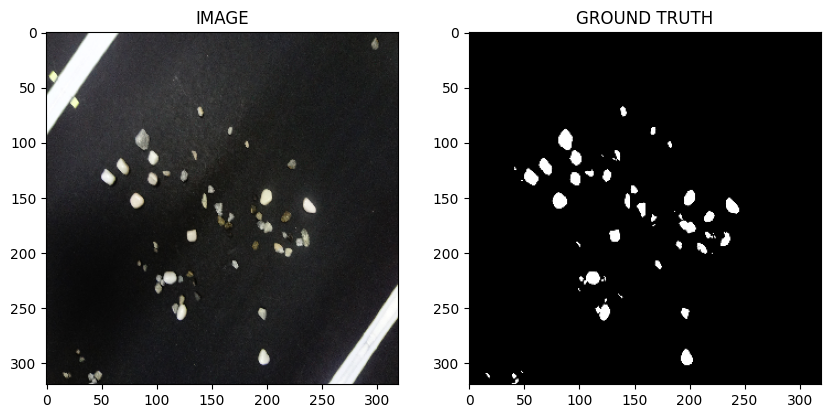

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Set title and display original image
ax1.set_title('IMAGE')
ax1.imshow(image)

# Set title and display mask image
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap='gray')

# Split the data into Two part Training and validation part

In [17]:
train_df , valid_df =train_test_split(df,test_size = 0.2,random_state=2)
print(train_df.shape,valid_df.shape)

(64, 2) (16, 2)


# Create Custom Dataset

## Reson-Get Image and mask pair according to E1 index



In [18]:
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.

        Args:
        idx (int): Index of the item to retrieve.

        Returns:
        tuple: A tuple containing the image and its corresponding mask.
            image (Tensor): Tensor representing the image.
            mask (Tensor): Tensor representing the mask.
        """
        row = self.df.iloc[idx]

        # Extract image and mask paths from the dataframe row
        image_path = row.images
        mask_path = row.masks

        # Read the image
        image = cv2.imread(image_path)
        # Convert image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the mask and add channel dimension
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        # Transpose image and mask to (C,H,W) format
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # Normalize image and mask
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask)) / 255.0

        return image, mask


In [19]:
trainset = SegmentationDataset(train_df)
validset = SegmentationDataset(valid_df)
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 64
Size of Validset : 16


# Create Show_image function
## to Show the custom data (image and mask pair in E1 index) and output_mask(if required)

In [20]:
def show_image(image, mask, pred_image=None):
    """
    Display the original image, ground truth mask, and predicted mask (if provided).

    Args:
    image (Tensor): Tensor representing the original image.
    mask (Tensor): Tensor representing the ground truth mask.
    pred_image (Tensor, optional): Tensor representing the predicted mask. Defaults to None.

    Returns:
    None
    """
    if pred_image is None:
        # Display original image and ground truth mask
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap='gray')
    else:
        # Display original image, ground truth mask, and predicted mask
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap='gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1, 2, 0).squeeze(), cmap='gray')


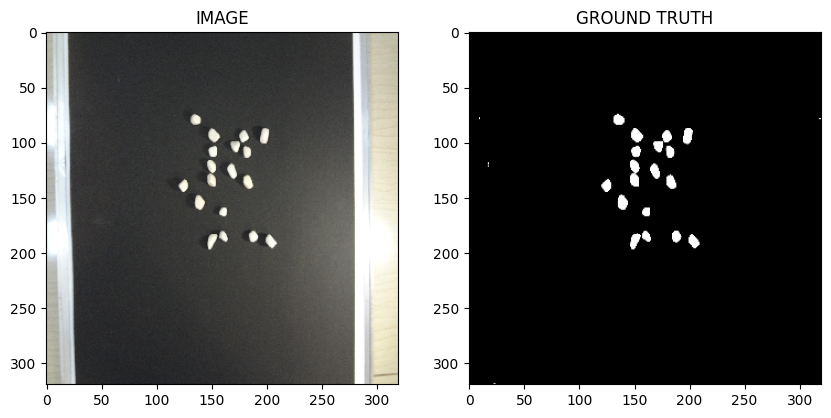

In [21]:
# Show the given image and mask
idx = 1
image , mask = trainset[idx]
show_image(image,mask)

# Load dataset into batches

In [22]:
trainloader = DataLoader(trainset,batch_size=4,shuffle=True)
validloader = DataLoader(validset,batch_size=2,shuffle=True)
print(f"Total number of bathches in trainloader : {len(trainloader)}")
print(f"Total number of bathches in validloader : {len(validloader)}")

Total number of bathches in trainloader : 16
Total number of bathches in validloader : 8


In [23]:
for image , mask in trainloader:
  break


print(f"One batch image shape {image.shape}")
print(f"One batch mask shape {mask.shape}")

One batch image shape torch.Size([4, 3, 320, 320])
One batch mask shape torch.Size([4, 1, 320, 320])


# Create Segmentation Model
## use segmentation_model_pytorch
## losses - DiceLoss and BCEWithLogitsLosds

In [24]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None

    )

  def forward(self,images,masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2

    return logits

In [25]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 62.1MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Create Train and Validation Function

In [26]:
def train_fun(data_loader, model, optimizer):
    """
    Function to perform training on the provided data loader, model, and optimizer.

    Args:
    data_loader (DataLoader): DataLoader object containing the training data.
    model (nn.Module): Model to be trained.
    optimizer (Optimizer): Optimizer for updating model parameters.

    Returns:
    float: Average training loss.
    """
    model.train()
    total_loss = 0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


In [27]:
def eval_fun(data_loader, model):
    """
    Function to evaluate the model on the provided data loader.

    Args:
    data_loader (DataLoader): DataLoader object containing the evaluation data.
    model (nn.Module): Model to be evaluated.

    Returns:
    float: Average evaluation loss.
    """
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)


# Train Model
## use Adam optimizer

In [28]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [29]:
best_valid_loss = np.Inf

train_loss=[]
valid_loss=[]
start=time.time()
for i in range(EPOCHS):

  t_loss = train_fun(trainloader,model,optimizer)
  v_loss = eval_fun(validloader,model)

  train_loss.append(t_loss)
  valid_loss.append(v_loss)

  if v_loss < best_valid_loss:
    torch.save(model.state_dict(),best_model_path)
    print("SAVED MODEL. ")
    best_valid_loss = v_loss

  print(f"Epoches : {i+1} train_loss: {t_loss} valid_loss: {v_loss}")


end=time.time()

100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


SAVED MODEL. 
Epoches : 1 train_loss: 1.0908181443810463 valid_loss: 0.6958178877830505


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


SAVED MODEL. 
Epoches : 2 train_loss: 0.36303669679909945 valid_loss: 0.21670928224921227


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


SAVED MODEL. 
Epoches : 3 train_loss: 0.1706332857720554 valid_loss: 0.15494488179683685


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


SAVED MODEL. 
Epoches : 4 train_loss: 0.14157865243032575 valid_loss: 0.14453244302421808


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoches : 5 train_loss: 0.13368483074009418 valid_loss: 0.37624121457338333


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


SAVED MODEL. 
Epoches : 6 train_loss: 0.13113181805238128 valid_loss: 0.13820845913141966


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SAVED MODEL. 
Epoches : 7 train_loss: 0.11797786923125386 valid_loss: 0.12268264498561621


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoches : 8 train_loss: 0.11428278777748346 valid_loss: 0.12668566778302193


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


SAVED MODEL. 
Epoches : 9 train_loss: 0.10980352107435465 valid_loss: 0.12018483690917492


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Epoches : 10 train_loss: 0.1066347872838378 valid_loss: 0.12326773069798946


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


SAVED MODEL. 
Epoches : 11 train_loss: 0.10000651003792882 valid_loss: 0.1172198485583067


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoches : 12 train_loss: 0.09653106797486544 valid_loss: 0.130762355402112


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoches : 13 train_loss: 0.09682786464691162 valid_loss: 0.1215048423036933


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoches : 14 train_loss: 0.08970433799549937 valid_loss: 0.1289487425237894


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


SAVED MODEL. 
Epoches : 15 train_loss: 0.08814487094059587 valid_loss: 0.11148983146995306


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoches : 16 train_loss: 0.08337368350476027 valid_loss: 0.11510405410081148


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoches : 17 train_loss: 0.08252766542136669 valid_loss: 0.11263293586671352


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoches : 18 train_loss: 0.08146236836910248 valid_loss: 0.1152145192027092


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoches : 19 train_loss: 0.08110474841669202 valid_loss: 0.11854459252208471


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

Epoches : 20 train_loss: 0.07870562095195055 valid_loss: 0.11377372965216637


In [30]:
training_time=end-start
print(f"\n Total Training Time {training_time/60} mimites")


 Total Training Time 32.128376317024234 mimites


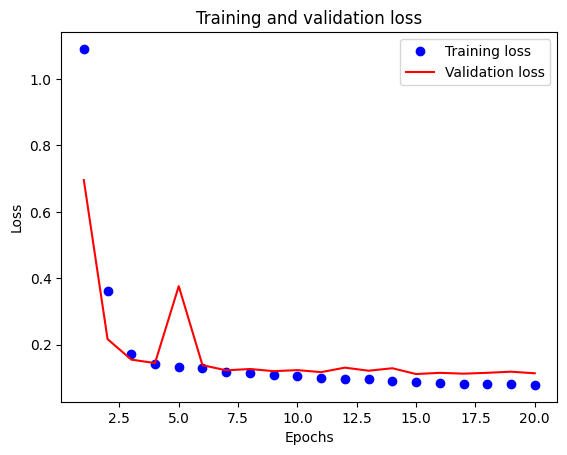

In [31]:
def plot_loss(train_loss, val_loss):
    """
    Plot the training and validation loss over epochs.

    Args:
    train_loss (list): List of training losses.
    val_loss (list): List of validation losses.

    Returns:
    None
    """
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_loss(train_loss, valid_loss)


# Plot Image,Ground_truth and Model_output for all validation data

In [32]:
for idx in range(len(validset)):
  model.load_state_dict(torch.load(best_model_path))

  image,mask = validset[idx]

  logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C,H,W) -> (1,C,H,W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask>0.5)*1.0
  pread_mask=pred_mask.detach().cpu().squeeze(0)

  show_image(image,mask,pread_mask)

Output hidden; open in https://colab.research.google.com to view.

# Calculate metrics


*   accuracy Score
*   IOU Score
*   f1_score
*   precision
*   Recall

for all validation dataset








In [33]:
# Assuming best_model_path, validset, and model are defined earlier
# Assuming DEVICE is defined earlier

# Load the trained model
model.load_state_dict(torch.load(best_model_path))

# Initialize lists to store metrics for all data points
accuracies = []
f1_scores = []
iou_scores = []
precisions = []
recalls = []

# Iterate over all samples in the validation set
for idx in range(len(validset)):
    # Get the image and mask for the current sample
    image, mask = validset[idx]

    # Process the image through the model
    logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)

    # Apply sigmoid activation and thresholding to get a binary mask prediction
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5).float()

    # Detach from the computation graph, move to CPU, and squeeze the batch dimension
    pred_mask = pred_mask.detach().cpu().squeeze(0)

    # Convert the target mask to integer type
    mask = mask.long()

    # Compute true positives, false positives, false negatives, and true negatives
    tp, fp, fn, tn = smp.metrics.get_stats(pred_mask, mask, mode='binary', threshold=0.5)

    # Compute metrics with required reduction
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")

    # Append metrics to the respective lists
    accuracies.append(accuracy.item())
    f1_scores.append(f1_score.item())
    iou_scores.append(iou_score.item())
    precisions.append(precision.item())
    recalls.append(recall.item())

# Calculate average metrics over all data points
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_iou_score = sum(iou_scores) / len(iou_scores)
average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)

print("Average Accuracy:", average_accuracy)
print("Average F1 Score:", average_f1_score)
print("Average IOU Score:", average_iou_score)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)


Average Accuracy: 0.994776014238596
Average F1 Score: 0.8896380998194218
Average IOU Score: 0.8014973029494286
Average Precision: 0.8310734331607819
Average Recall: 0.9574617743492126
